# **Import Modules**

In [75]:
# Numpy is needed for data generation
import numpy as np
# Pytorch is needed for model build
import torch

# **Data Generation**

In [76]:
# We use this line to make the code reproducible (to get the same results when running)
np.random.seed(42)
# First, we should declare a variable containing the size of the training set we want to generate
observations = 1000

# Let us assume we have the following relationship
# y = 13x + 2
# y is the output and x is the input or feature
# We generate the feature randomly, drawing from an uniform distribution. There are 3 arguments of this method (low, high, size).
# The size of x is observations by 1. In this case: 1000 x 1.
x = np.random.uniform(low=-10, high=10, size=(observations,1))

# We add a small noise to our function for more randomness
noise = np.random.uniform(-1, 1, (observations,1))

# Produce the targets according to the f(x) = 13x + 2 + noise definition.
# This is a simple linear relationship with one weight and bias.
# In this way, we are basically saying: the weight is 13 and the bias is 2.
targets = 13*x + 2 + noise

# **Data Preparation**

In [77]:
# TensorDataset is needed to prepare the training data in form of tensors
from torch.utils.data import TensorDataset

# To run the model on either the CPU or GPU (if available)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Since torch deals with tensors, we convert the numpy arrays into torch tensors
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(targets).float()

# Combine the feature tensor and target tensor into torch dataset
train_data = TensorDataset(x_tensor , y_tensor)
train_data[1]

(tensor([9.0143]), tensor([119.2695]))

# **DataLoader**

In [78]:
# DataLoader is needed for data batching
from torch.utils.data import DataLoader

# Training dataset is converted into batches of size 16 samples each.
# Shuffling is enabled for randomizing the data
train_loader = DataLoader(train_data , batch_size = 16 , shuffle = True)

In [79]:
# You can retrieve the batches
#next(iter(train_loader))

# **Model Build**

In [80]:
# Initialize the seed to make the code reproducible
torch.manual_seed(42)

# This function is for model's parameters initialization
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.uniform_(m.weight , a = -0.1 , b = 0.1)
        torch.nn.init.uniform_(m.bias , a = -0.1 , b = 0.1)

# Define the model using Sequential class
# It contains only a single linear layer with one input and one output
model = torch.nn.Sequential(torch.nn.Linear(1 , 1)).to(device)

# Initialize the model's parameters using the defined function from above
model.apply(init_weights)

# Print the model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[0.0226]], device='cuda:0')), ('0.bias', tensor([0.0975], device='cuda:0'))])


# **Model Compile**

In [81]:
# Specify the learning rate
lr = 0.02

# The loss function is the mean squared error
loss_fn = torch.nn.MSELoss(reduction = 'mean')

# The optimizer is the stochastic gradient descent with a certain learning rate
optimizer = torch.optim.SGD(model.parameters() , lr = lr)

# **Training Process**

In [82]:
# A function for training the model
# It is a function of a function (How fancy)
def make_train_step(model , optimizer , loss_fn):
  def train_step(x , y):
    # Set the model to training mode
    model.train()
    # Feedforward the model with the data (features) to obtain the predictions
    yhat = model(x)
    # Calculate the loss based on the predicted and actual targets
    loss = loss_fn(y , yhat)
    # Perform the backpropagation to find the gradients
    loss.backward()
    # Update the parameters with the calculated gradients
    optimizer.step()
    # Set the gradients to zero to prevent accumulation
    optimizer.zero_grad()
    return loss.item()
  return train_step

# Call the training function
train_step = make_train_step(model , optimizer , loss_fn)

# To store the loss of each epoch
losses = []

# Set the epochs to 100
epochs = 100

# Run the training function in each epoch on the batches of the data
# This is why we have two for loops
# Outer loop for epochs
# Inner loop for iterating through the training data batches
for epoch in range(epochs):
  # To accumulate the losses of all batches within a single epoch
  batch_loss = 0
  for x_batch , y_batch in train_loader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    loss = train_step(x_batch , y_batch)
    batch_loss = batch_loss + loss
  # 63 is not a magic number. It is the number of batches in the training set
  # we have 1000 samples and the batch size is 16 (defined in the DataLoader)
  # 1000/16 = 63
  epoch_loss = batch_loss / 63
  losses.append(epoch_loss)

# Print the parameters after the training is done
print(model.state_dict())

OrderedDict([('0.weight', tensor([[13.0287]], device='cuda:0')), ('0.bias', tensor([2.0096], device='cuda:0'))])


# **Training Loss**

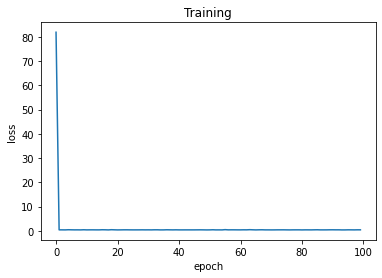

In [83]:
# Matplotlib is needed for visualization
import matplotlib.pyplot as plt

# Plot epochs and losses
plt.plot(range(100),losses)

# Add labels to x axis and y axis
plt.ylabel('loss')
plt.xlabel('epoch')

# Add title to the graph
plt.title('Training')

# Show the plot
# The curve is decreasing in each epoch, which is what we need
# After several epochs, we can see that the curve is flattened.
# This means the algorithm has converged and hence there are no significant updates
# or changes in the weights or biases.
plt.show()

# **Predicted Vs Real Targets**

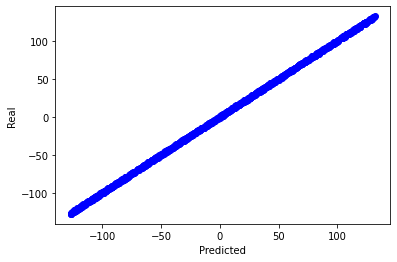

In [95]:
# We print the real and predicted targets in order to see if they have a linear relationship.
# There is almost a total match between the real targets and predicted targets.
# This is a good signal of the success of our machine learning model.

# Set the model to prediction mode
model.eval()

# Move the training data to GPU because the model is on the GPU as well
x_tensor = x_tensor.to(device)

# Calculate the predicted targets
# Move them back to the CPU and detach to convert them to numpy array
outputs = model(x_tensor).cpu().detach().numpy()

# Plot the real and predicted
plt.plot(outputs,targets, 'bo')

# Label the x axis and y axis
plt.xlabel('Predicted')
plt.ylabel('Real')

# Display the plot
plt.show()